In [376]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB
# to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [377]:
import lightgbm

Ввиду большого количества переменных - номинально 80, но из-за наличия большого количества categorical variables итоговое количество переменных с OneHotEncoding будет коллосальным относительно небольшой выборки в 1400 наблюдений, слишком тяжело (или невозможно) реализовать Backward-selection, поэтому я решил пойти путем forward-selection, но для того чтобы определить очередность включения переменных в модель, надо получить их feature importance. Для этого предлагаю использовать lightgbm от Google, и feature importance из их модели-дерева.  

Также хотелось бы отметить, что логичнее оценивать не суммарную стоимость обьекта, а стоимость одного квадратного метра (это классическая интерпретация цен на недвижимость). При этом переменные, по типу Gross Living Area логично выразить в виде доли от общего LotArea

In [378]:
import matplotlib.pyplot as plt

In [396]:
train = pd.read_csv('train.csv') 
train['SalePrice'] = np.log1p(train['SalePrice']/train['LotArea'])
lot_area = train.pop('LotArea')
ids = train.pop('Id')

In [397]:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [398]:
cat_names = ['MSSubClass',
'MSZoning',
'Street',
'Alley',
'LotShape',
'LandContour',
'Utilities',
'LotConfig',
'LandSlope',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'OverallQual',
'OverallCond',
'RoofStyle',
'RoofMatl',
'Exterior1st',
'Exterior2nd',
'MasVnrType',
'ExterQual',
'ExterCond',
'Foundation',
'BsmtQual',
'BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinType2',
'Heating',
'HeatingQC',
'CentralAir',
'Electrical',
'KitchenQual',
'Functional',
'FireplaceQu',
'GarageType',
'GarageFinish',
'GarageQual',
'GarageCond',
'PavedDrive',
'PoolQC',
'Fence',
'MiscFeature',
'SaleType',
'SaleCondition']

In [399]:
cat_idx = [list(ctrain.columns).index(x) for x in cat_names]
train[cat_names] = train[cat_names].fillna('NA')
test[cat_names] = test[cat_names].fillna('NA')

In [400]:
from sklearn.preprocessing import LabelEncoder

In [401]:
le = LabelEncoder()

In [402]:
for cat in cat_names:
    le.fit(pd.concat([train[cat], test[cat]]))
    train[cat] = le.transform(train[cat])
    test[cat] = le.transform(test[cat])

In [403]:
lgb = lightgbm.LGBMRegressor(importance_type='gain')

In [404]:
y_train = train.pop('SalePrice')

In [405]:
lgb.fit(train, y_train,categorical_feature=cat_names)

C:\Users\a_che\Anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='gain', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [406]:
feat_imp, names = zip(*sorted(zip(lgb.feature_importances_,train.columns)))

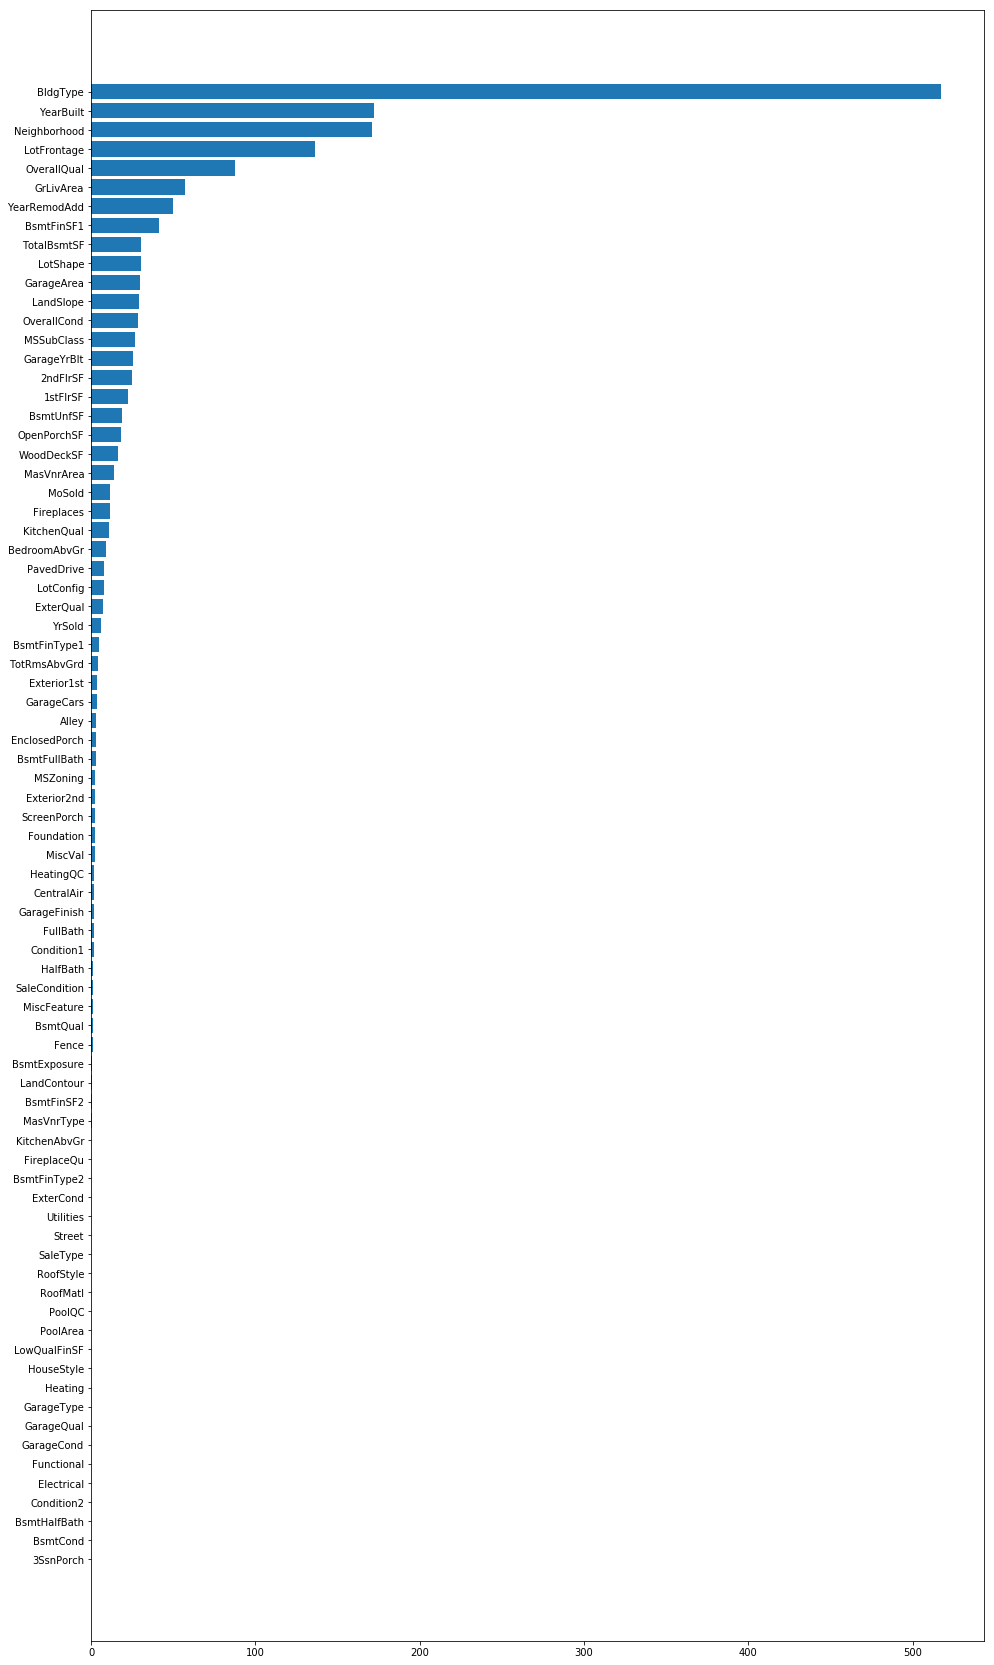

In [407]:
plt.figure(figsize = (16,30))
plt.barh(names, feat_imp)
plt.show()

Таким образом, мы получаем список фичей, отранжированных по значимости. Пойдем от наиболее важных BldgType, YearBuilt, Neighborhood и так далее. Поскольку мы искали важность фичей для log(Price/LotArea) => можно сделать регрессию вида log(Price) ~ log(LotArea) * (....)

In [646]:
train = pd.read_csv('train.csv') 
train['SalePrice'] = np.log1p(train['SalePrice'])
train_y = train['SalePrice']
train.pop('SalePrice')

test = pd.read_csv('test.csv')
cat_idx = [list(ctrain.columns).index(x) for x in cat_names]

train[cat_names] = train[cat_names].fillna('NA')
test[cat_names] = test[cat_names].fillna('NA')

le = LabelEncoder()
for cat in cat_names:
    le.fit(pd.concat([train[cat], test[cat]]))
    train[cat] = le.transform(train[cat])
    test[cat] = le.transform(test[cat])
    


In [647]:
train = pd.concat([train, train_y], axis = 1)

In [648]:
pd.options.display.max_columns = 90

In [649]:
train['LotArea'] = np.log1p(train['LotArea'])
test['LotArea'] = np.log1p(test['LotArea'])

Готовим переменные

In [650]:
train = pd.get_dummies(train, prefix = 'BldgType', columns = ['BldgType'])
test = pd.get_dummies(test, prefix = 'BldgType', columns = ['BldgType'])


In [651]:
dum_labels = ['BldgType_0','BldgType_1','BldgType_2','BldgType_3','BldgType_4']
for i in range(0,len(dum_labels)):
    train[dum_labels[i]] = train[dum_labels[i]]*train['LotArea']
    test[dum_labels[i]] = test[dum_labels[i]]*test['LotArea']
    


In [652]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4
0,1,5,4,65.0,9.042040,1,1,3,3,0,4,0,5,2,2,5,6,4,2003,2003,1,1,13,14,1,196.0,2,4,2,2,4,4,2,706,6,0,150,856,1,0,1,5,856,854,0,1710,1,0,2,1,3,1,2,8,7,0,3,1,2003.0,2,2,548,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,9,4,12.247699,9.042040,0.0,0.0,0.0,0.0
1,2,0,4,80.0,9.169623,1,1,3,3,0,2,0,24,1,2,2,5,7,1976,1976,1,1,8,8,3,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,0,1,2,0,3,1,4,6,7,1,5,1,1976.0,2,2,460,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,9,4,12.109016,9.169623,0.0,0.0,0.0,0.0
2,3,5,4,68.0,9.328212,1,1,0,3,0,4,0,5,2,2,5,6,4,2001,2002,1,1,13,14,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,5,920,866,0,1786,1,0,2,1,3,1,2,6,7,1,5,1,2001.0,2,2,608,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,9,4,12.317171,9.328212,0.0,0.0,0.0,0.0
3,4,6,4,60.0,9.164401,1,1,0,3,0,0,0,6,2,2,5,6,4,1915,1970,1,1,14,16,3,0.0,3,4,0,4,1,4,0,216,6,0,540,756,1,2,1,5,961,756,0,1717,1,0,1,0,3,1,2,7,7,1,2,5,1998.0,3,3,642,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,9,0,11.849405,9.164401,0.0,0.0,0.0,0.0
4,5,5,4,84.0,9.565284,1,1,0,3,0,2,0,15,2,2,5,7,4,2000,2000,1,1,13,14,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,1,0,2,1,4,1,2,9,7,1,5,1,2000.0,2,3,836,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,9,4,12.429220,9.565284,0.0,0.0,0.0,0.0


In [653]:
labels = ['LotArea','BldgType_0','BldgType_1','BldgType_2','BldgType_3']

In [654]:
from sklearn.linear_model import SGDRegressor

In [655]:
from sklearn.model_selection import KFold

In [656]:
kf = KFold(n_splits=10)
kf.get_n_splits(train)

10

In [657]:
from sklearn.metrics import mean_squared_error

In [658]:
print(kf)
model = SGDRegressor()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, labels], train.loc[test_index, labels]
    y_train, y_test = train.loc[train_index, 'SalePrice'], train.loc[test_index, 'SalePrice']

    model.fit(X_train, y_train)
    print("model.coef_: ", model.coef_)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=10, random_state=None, shuffle=False)
model.coef_:  [ 1.40654684 -0.13553962 -0.18825578 -0.15553244  0.08028809]
0 0.3849162308791325
model.coef_:  [ 1.38724074 -0.12965342 -0.1996409  -0.15240748  0.09251923]
1 0.5329491640087746
model.coef_:  [ 1.41082913 -0.14823314 -0.15550202 -0.14139333  0.06842964]
2 0.626352987179576
model.coef_:  [ 1.39292727 -0.13359273 -0.18175927 -0.14683873  0.09069693]
3 0.5150498271427125
model.coef_:  [ 1.40903097 -0.12289525 -0.16607769 -0.15540244  0.08048679]
4 0.5351240346158519
model.coef_:  [ 1.39645299 -0.11813953 -0.16624966 -0.15390113  0.07811172]
5 0.394477844947187
model.coef_:  [ 1.38826892 -0.11176111 -0.19899707 -0.14172631  0.0829352 ]
6 0.48014084787480404
model.coef_:  [ 1.39316489 -0.12857742 -0.16697629 -0.16156162  0.08744165]
7 0.4160839689960669
model.coef_:  [ 1.38973388 -0.11426095 -0.17718063 -0.14508619  0.08332894]
8 0.43843276661448644
model.coef_:  [ 1.3967722  -0.14942359 -0.1580213  -0.14931079  0.08940402

In [659]:
model = SGDRegressor()

In [660]:
model.fit(train[labels], train['SalePrice'])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [661]:
model.coef_

array([ 1.39480576, -0.11650271, -0.20027722, -0.14715423,  0.07955944])

In [662]:
model.intercept_

array([0.32759002])

In [663]:
prediction = model.predict(test[labels])

In [664]:
sample_submission['SalePrice']=  np.exp(prediction)-1

In [665]:
sample_submission.to_csv('submission.csv', index = None)

1. Первый submission дал public result 0.47, при среднем значении на кросс-валидации в 0.49

Добавляем Year Built в модель

In [666]:
_max = max(max(train['YearBuilt']), max(test['YearBuilt']))
_min = min(min(train['YearBuilt']), min(test['YearBuilt']))
train['YearBuilt'], test['YearBuilt'] = (train['YearBuilt'] - _min)/_max, (test['YearBuilt'] - _min)/_max


In [667]:
train['YearBuilt'], test['YearBuilt'] = train['YearBuilt']*train['LotArea'], test['YearBuilt']*test['LotArea']

In [668]:
labels.append('YearBuilt')
labels

['LotArea',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'YearBuilt']

In [669]:
print(kf)
model = SGDRegressor()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, labels], train.loc[test_index, labels]
    y_train, y_test = train.loc[train_index, 'SalePrice'], train.loc[test_index, 'SalePrice']

    model.fit(X_train, y_train)
    print("model.coef_: ", model.coef_)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=10, random_state=None, shuffle=False)
model.coef_:  [ 1.39416941 -0.14132311 -0.16819328 -0.14658071  0.08125402  0.22467327]
0 0.3799729198199654
model.coef_:  [ 1.38541922 -0.14028719 -0.1744943  -0.14706198  0.08530346  0.22642447]
1 0.5195622026497552
model.coef_:  [ 1.35141443 -0.16410308 -0.1504526  -0.1497551   0.08157481  0.18092445]
2 0.8699384315148029
model.coef_:  [ 1.39072003 -0.14131379 -0.16042408 -0.13535982  0.09034848  0.20535554]
3 0.5128916725708502
model.coef_:  [ 1.39456449 -0.13117883 -0.16630234 -0.13880379  0.08005494  0.23822422]
4 0.5168688424904571
model.coef_:  [ 1.39075284 -0.14476466 -0.16872531 -0.13681219  0.08753026  0.21838515]
5 0.4069743715294724
model.coef_:  [ 1.39023143 -0.12353768 -0.16662076 -0.14162019  0.08227228  0.19940346]
6 0.4635265496305615
model.coef_:  [ 1.39243859 -0.13720896 -0.14800303 -0.14376082  0.08730567  0.23956264]
7 0.4094332513296989
model.coef_:  [ 1.3957074  -0.11536613 -0.17745397 -0.13392686  0.08917723 

In [670]:
model = SGDRegressor()

In [671]:
model.fit(train[labels], train['SalePrice'])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [672]:
model.coef_

array([ 1.39359985, -0.12439345, -0.1691287 , -0.14305348,  0.08547439,
        0.22011249])

In [673]:
model.intercept_

array([0.32608121])

In [674]:
prediction = model.predict(test[labels])

In [675]:
sample_submission['SalePrice']=  np.exp(prediction)-1

In [676]:
sample_submission.to_csv('submission.csv', index = None)

2. Второй submission дал public result 0.46, при среднем значении на кросс-валидации в 0.512

Добавляем Neighborhood в модель

In [677]:
train = pd.get_dummies(train, prefix = 'Neigh', columns = ['Neighborhood'])
test = pd.get_dummies(test, prefix = 'Neigh', columns = ['Neighborhood'])

In [678]:
for i in range(0,25):
    train['Neigh_'+str(i)] = train['Neigh_'+str(i)]*train['LotArea']
    test['Neigh_'+str(i)] = test['Neigh_'+str(i)]*test['LotArea']
  


In [679]:
for i in range(0,25):
    labels.append('Neigh_'+str(i))
labels

['LotArea',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'YearBuilt',
 'Neigh_0',
 'Neigh_1',
 'Neigh_2',
 'Neigh_3',
 'Neigh_4',
 'Neigh_5',
 'Neigh_6',
 'Neigh_7',
 'Neigh_8',
 'Neigh_9',
 'Neigh_10',
 'Neigh_11',
 'Neigh_12',
 'Neigh_13',
 'Neigh_14',
 'Neigh_15',
 'Neigh_16',
 'Neigh_17',
 'Neigh_18',
 'Neigh_19',
 'Neigh_20',
 'Neigh_21',
 'Neigh_22',
 'Neigh_23',
 'Neigh_24']

In [680]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,Neigh_0,Neigh_1,Neigh_2,Neigh_3,Neigh_4,Neigh_5,Neigh_6,Neigh_7,Neigh_8,Neigh_9,Neigh_10,Neigh_11,Neigh_12,Neigh_13,Neigh_14,Neigh_15,Neigh_16,Neigh_17,Neigh_18,Neigh_19,Neigh_20,Neigh_21,Neigh_22,Neigh_23,Neigh_24
0,1,5,4,65.0,9.042040,1,1,3,3,0,4,0,2,2,5,6,4,0.589307,2003,1,1,13,14,1,196.0,2,4,2,2,4,4,2,706,6,0,150,856,1,0,1,5,856,854,0,1710,...,0,61,0,0,0,0,3,4,1,0,2,2008,9,4,12.247699,9.042040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.042040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2,0,4,80.0,9.169623,1,1,3,3,0,2,0,1,2,2,5,7,0.474448,1976,1,1,8,8,3,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,...,298,0,0,0,0,0,3,4,1,0,5,2007,9,4,12.109016,9.169623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.169623
2,3,5,4,68.0,9.328212,1,1,0,3,0,4,0,2,2,5,6,4,0.598676,2002,1,1,13,14,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,5,920,866,0,1786,...,0,42,0,0,0,0,3,4,1,0,9,2008,9,4,12.317171,9.328212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.328212,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,4,6,4,60.0,9.164401,1,1,0,3,0,0,0,2,2,5,6,4,0.196054,1970,1,1,14,16,3,0.0,3,4,0,4,1,4,0,216,6,0,540,756,1,2,1,5,961,756,0,1717,...,0,35,272,0,0,0,3,4,1,0,2,2006,9,0,11.849405,9.164401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.164401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,5,5,4,84.0,9.565284,1,1,0,3,0,2,0,2,2,5,7,4,0.609133,2000,1,1,13,14,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,...,192,84,0,0,0,0,3,4,1,0,12,2008,9,4,12.429220,9.565284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.565284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [681]:
from sklearn.linear_model import SGDRegressor

In [682]:
from sklearn.model_selection import KFold

In [683]:
kf = KFold(n_splits=10)
kf.get_n_splits(train)

10

In [684]:
from sklearn.metrics import mean_squared_error

In [685]:
print(kf)
model = SGDRegressor()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, labels], train.loc[test_index, labels]
    y_train, y_test = train.loc[train_index, 'SalePrice'], train.loc[test_index, 'SalePrice']

    model.fit(X_train, y_train)
    print("model.coef_: ", model.coef_)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=10, random_state=None, shuffle=False)
model.coef_:  [ 1.31556522 -0.08350332 -0.13965491 -0.09940904  0.06992999  0.13755017
  0.14375164  0.11507613  0.13744358  0.03831725 -0.0636893   0.05965279
  0.04810239  0.02369624  0.04819881  0.00992816  0.11138919  0.01088419
  0.01562907  0.10969876  0.03342771  0.0774725   0.0689663   0.05971615
  0.05677204  0.00334799  0.03997751  0.10123605  0.06329149 -0.00256969
  0.00584826]
0 0.3601695007826857
model.coef_:  [ 1.32803643e+00 -7.58913307e-02 -1.44805358e-01 -8.87328558e-02
  7.04351011e-02  1.29884839e-01  1.42079685e-01  1.11747160e-01
  1.21308492e-01  4.85250504e-02 -3.48383938e-02  6.13678515e-02
  3.51902479e-02  3.96922355e-02  4.85944979e-02  1.49871084e-02
  1.05722570e-01  1.12537199e-02  2.92505780e-03  8.79658332e-02
  3.66773300e-02  7.65451482e-02  7.02704471e-02  6.46948124e-02
  6.23467116e-02  9.56974517e-03  3.51636702e-02  8.67739012e-02
  8.07640313e-02  2.85201990e-04  8.42431799e-03]
1 0.4585082877

In [686]:
model = SGDRegressor()

In [687]:
model.fit(train[labels], train['SalePrice'])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [688]:
model.coef_

array([ 1.31336399, -0.06663111, -0.15414   , -0.08427948,  0.07563782,
        0.14643111,  0.14174608,  0.10655839,  0.12378128,  0.0394084 ,
       -0.01575561,  0.06020772,  0.02479152,  0.02001345,  0.02717543,
        0.0283781 ,  0.10295388,  0.01815811,  0.01965546,  0.09010303,
        0.02892646,  0.07902317,  0.06989045,  0.07172357,  0.06070663,
        0.02353448,  0.03909287,  0.08983518,  0.08650229, -0.02672419,
        0.00367783])

In [689]:
model.intercept_

array([0.28852487])

In [690]:
prediction = model.predict(test[labels])

In [691]:
sample_submission['SalePrice']=  np.exp(prediction)-1

In [692]:
sample_submission.to_csv('submission.csv', index = None)

3. Третий submission дал public result 0.44, при среднем значении на кросс-валидации в 0.438

Теперь добавляем OverallQual (пропустим LotFrontage, потому что OverallQual по смыслу подходит значительно больше). Поскольку переменная ординальная, мы можем иоставить LabelEncoding, чтобы не услугублять проблем с оверфиттингом. 

In [693]:
train['OverallQual'] = train['OverallQual']/10
test['OverallQual'] = test['OverallQual']/10

In [694]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,Neigh_0,Neigh_1,Neigh_2,Neigh_3,Neigh_4,Neigh_5,Neigh_6,Neigh_7,Neigh_8,Neigh_9,Neigh_10,Neigh_11,Neigh_12,Neigh_13,Neigh_14,Neigh_15,Neigh_16,Neigh_17,Neigh_18,Neigh_19,Neigh_20,Neigh_21,Neigh_22,Neigh_23,Neigh_24
0,1,5,4,65.0,9.042040,1,1,3,3,0,4,0,2,2,5,0.6,4,0.589307,2003,1,1,13,14,1,196.0,2,4,2,2,4,4,2,706,6,0,150,856,1,0,1,5,856,854,0,1710,...,0,61,0,0,0,0,3,4,1,0,2,2008,9,4,12.247699,9.042040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.042040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2,0,4,80.0,9.169623,1,1,3,3,0,2,0,1,2,2,0.5,7,0.474448,1976,1,1,8,8,3,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,...,298,0,0,0,0,0,3,4,1,0,5,2007,9,4,12.109016,9.169623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.169623
2,3,5,4,68.0,9.328212,1,1,0,3,0,4,0,2,2,5,0.6,4,0.598676,2002,1,1,13,14,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,5,920,866,0,1786,...,0,42,0,0,0,0,3,4,1,0,9,2008,9,4,12.317171,9.328212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.328212,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,4,6,4,60.0,9.164401,1,1,0,3,0,0,0,2,2,5,0.6,4,0.196054,1970,1,1,14,16,3,0.0,3,4,0,4,1,4,0,216,6,0,540,756,1,2,1,5,961,756,0,1717,...,0,35,272,0,0,0,3,4,1,0,2,2006,9,0,11.849405,9.164401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.164401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,5,5,4,84.0,9.565284,1,1,0,3,0,2,0,2,2,5,0.7,4,0.609133,2000,1,1,13,14,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,...,192,84,0,0,0,0,3,4,1,0,12,2008,9,4,12.429220,9.565284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.565284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [695]:
train['OverallQual'] = train['OverallQual']*train['LotArea']
test['OverallQual'] = test['OverallQual']*test['LotArea']
  


In [696]:
labels.append('OverallQual')
labels

['LotArea',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'YearBuilt',
 'Neigh_0',
 'Neigh_1',
 'Neigh_2',
 'Neigh_3',
 'Neigh_4',
 'Neigh_5',
 'Neigh_6',
 'Neigh_7',
 'Neigh_8',
 'Neigh_9',
 'Neigh_10',
 'Neigh_11',
 'Neigh_12',
 'Neigh_13',
 'Neigh_14',
 'Neigh_15',
 'Neigh_16',
 'Neigh_17',
 'Neigh_18',
 'Neigh_19',
 'Neigh_20',
 'Neigh_21',
 'Neigh_22',
 'Neigh_23',
 'Neigh_24',
 'OverallQual']

In [697]:
kf = KFold(n_splits=10)
kf.get_n_splits(train)

10

In [698]:
print(kf)
model = SGDRegressor()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, labels], train.loc[test_index, labels]
    y_train, y_test = train.loc[train_index, 'SalePrice'], train.loc[test_index, 'SalePrice']

    model.fit(X_train, y_train)
    print("model.coef_: ", model.coef_)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=10, random_state=None, shuffle=False)
model.coef_:  [ 1.27079766 -0.10161485 -0.11698698 -0.0778856   0.07100247  0.1023887
  0.12819417  0.1145539   0.1316788   0.06473495 -0.0111018   0.04392366
  0.04127577  0.02797859  0.0280271   0.01569455  0.12165395  0.01556813
  0.03479038  0.10319914  0.03014158  0.04044362  0.04148197  0.03909453
  0.06961773  0.03505953  0.03258998  0.066737    0.04711014  0.00652029
  0.00183     0.11522166]
0 0.3405125634746097
model.coef_:  [ 1.27208981 -0.08499415 -0.13053045 -0.09825735  0.06984026  0.11675166
  0.12534015  0.10379489  0.12092726  0.06879841 -0.03460202  0.05577744
  0.04736136  0.02584977  0.0448489   0.02898733  0.11551155 -0.01115889
  0.04423769  0.08534571  0.01686783  0.04436789  0.05301359  0.07722833
  0.05963378  0.01643069  0.03283406  0.08096931  0.06990129 -0.00158837
  0.00141185  0.10474867]
1 0.4478156443853712
model.coef_:  [ 1.27488976 -0.09996189 -0.10224617 -0.09946486  0.07413857  0.09539911
  0.12214

In [699]:
model = SGDRegressor()

In [700]:
model.fit(train[labels], train['SalePrice'])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [701]:
model.coef_

array([ 1.24712048, -0.09769654, -0.13611177, -0.09162494,  0.07174978,
        0.10579596,  0.13128813,  0.11004553,  0.13056829,  0.07782496,
       -0.01707512,  0.06125708,  0.02296273,  0.02003318,  0.0368904 ,
        0.01354454,  0.10860448,  0.01521769,  0.03725455,  0.08849376,
        0.01920351,  0.0465137 ,  0.05718965,  0.04911086,  0.06637542,
        0.03317898,  0.03168569,  0.08460115,  0.05415078, -0.03479928,
        0.00299981,  0.09274331])

In [702]:
model.intercept_

array([0.28062387])

In [703]:
prediction = model.predict(test[labels])

In [704]:
sample_submission['SalePrice']=  np.exp(prediction)-1

In [705]:
sample_submission.to_csv('submission.csv', index = None)

 4. Четвертый submission дал public result 0.39253, при среднем значении на кросс-валидации в 0.433

Добавим в модель факторы, связанные с жилой площадью и площадью гаража. Думаю, что Gross Living Area логично интерпретировать как долю от LotArea, тогда как от Garage Area возьмем min-max.


In [706]:
train['GrLivArea'] = train['GrLivArea']/(np.exp(train['LotArea'] + 1))*train['LotArea']
test['GrLivArea'] = test['GrLivArea']/(np.exp(test['LotArea'] + 1))*test['LotArea']
_max = max(max(train['GarageArea']), max(test['GarageArea']))
_min = min(min(train['GarageArea']), min(test['GarageArea']))
train['GarageArea'] = (train['GarageArea'] - _min)/(_max - _min)
test['GarageArea'] = (test['GarageArea'] - _min)/(_max - _min)

In [707]:
train['GarageArea'] = train['GarageArea']*train['LotArea']
test['GarageArea'] = test['GarageArea']*train['LotArea']

In [708]:
test['GarageArea'] = test['GarageArea'].fillna(0)
train['GarageArea'] = train['GarageArea'].fillna(0)

In [709]:
labels.append('GrLivArea')
labels.append('GarageArea')
labels

['LotArea',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'YearBuilt',
 'Neigh_0',
 'Neigh_1',
 'Neigh_2',
 'Neigh_3',
 'Neigh_4',
 'Neigh_5',
 'Neigh_6',
 'Neigh_7',
 'Neigh_8',
 'Neigh_9',
 'Neigh_10',
 'Neigh_11',
 'Neigh_12',
 'Neigh_13',
 'Neigh_14',
 'Neigh_15',
 'Neigh_16',
 'Neigh_17',
 'Neigh_18',
 'Neigh_19',
 'Neigh_20',
 'Neigh_21',
 'Neigh_22',
 'Neigh_23',
 'Neigh_24',
 'OverallQual',
 'GrLivArea',
 'GarageArea']

In [710]:
kf = KFold(n_splits=10)
kf.get_n_splits(train)

10

In [711]:
print(kf)
model = SGDRegressor()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, labels], train.loc[test_index, labels]
    y_train, y_test = train.loc[train_index, 'SalePrice'], train.loc[test_index, 'SalePrice']

    model.fit(X_train, y_train)
    print("model.coef_: ", model.coef_)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=10, random_state=None, shuffle=False)
model.coef_:  [ 1.22571895 -0.06643413 -0.08352257 -0.0769672   0.02633641  0.11927935
  0.10652839  0.06835311  0.09025436  0.05717579 -0.04101817  0.05681534
  0.04193609  0.03353584  0.04486144  0.01640144  0.09701481  0.03376122
  0.03324596  0.08642499  0.02603255  0.05966847  0.06659804  0.04078422
  0.0521661   0.025922    0.04549755  0.0762057   0.05383266  0.03238682
  0.02133423  0.09732347  0.57803956 -0.03268842]
0 0.27075229313660537
model.coef_:  [ 1.24319103 -0.0621258  -0.09679794 -0.07627848  0.03343977  0.1171651
  0.10472084  0.07863214  0.09138838  0.05826635 -0.02690235  0.05803398
  0.04709871  0.02568705  0.0443942   0.02154538  0.10150846  0.02205751
  0.04239255  0.08623536  0.03938381  0.04951151  0.06339947  0.05660681
  0.04893027  0.04100105  0.04070674  0.069359    0.06145772  0.00396695
  0.01380913  0.10017334  0.50828717 -0.02940962]
1 0.396495738009862
model.coef_:  [ 1.23454233 -0.07340208 -0.087050

In [712]:
model = SGDRegressor()

In [713]:
model.fit(train[labels], train['SalePrice'])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [714]:
model.coef_

array([ 1.21738858, -0.06623705, -0.11157449, -0.05467562,  0.0295546 ,
        0.1246256 ,  0.10573442,  0.06938651,  0.08968464,  0.06605931,
       -0.02677627,  0.06159859,  0.04134604,  0.02461173,  0.03849349,
        0.03161681,  0.09217722,  0.02211682,  0.03990959,  0.07763615,
        0.03443695,  0.04642416,  0.06760627,  0.0387585 ,  0.04280551,
        0.04088549,  0.03320601,  0.07219226,  0.06272014,  0.01747445,
        0.02728378,  0.10070883,  0.60498147, -0.03439147])

In [715]:
model.intercept_

array([0.27823128])

In [716]:
prediction = model.predict(test[labels])

In [717]:
sample_submission['SalePrice']=  np.exp(prediction)-1

In [718]:
sample_submission.to_csv('submission.csv', index = None)

 5. Пятый submission дал public result 0.33429, при среднем значении на кросс-валидации в 0.3535

Добавим в модель фактор OverallCond. Он ординален, как и OverallQual, поэтому оставим его в LabelEncoding.  

In [719]:
train['OverallCond'] = train['OverallCond']/10
test['OverallCond'] = test['OverallCond']/10

In [720]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,Neigh_0,Neigh_1,Neigh_2,Neigh_3,Neigh_4,Neigh_5,Neigh_6,Neigh_7,Neigh_8,Neigh_9,Neigh_10,Neigh_11,Neigh_12,Neigh_13,Neigh_14,Neigh_15,Neigh_16,Neigh_17,Neigh_18,Neigh_19,Neigh_20,Neigh_21,Neigh_22,Neigh_23,Neigh_24
0,1,5,4,65.0,9.042040,1,1,3,3,0,4,0,2,2,5,5.425224,0.4,0.589307,2003,1,1,13,14,1,196.0,2,4,2,2,4,4,2,706,6,0,150,856,1,0,1,5,856,854,0,0.673070,...,0,61,0,0,0,0,3,4,1,0,2,2008,9,4,12.247699,9.042040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.042040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2,0,4,80.0,9.169623,1,1,3,3,0,2,0,1,2,2,4.584811,0.7,0.474448,1976,1,1,8,8,3,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,0.443404,...,298,0,0,0,0,0,3,4,1,0,5,2007,9,4,12.109016,9.169623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.169623
2,3,5,4,68.0,9.328212,1,1,0,3,0,4,0,2,2,5,5.596927,0.4,0.598676,2002,1,1,13,14,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,5,920,866,0,0.544746,...,0,42,0,0,0,0,3,4,1,0,9,2008,9,4,12.317171,9.328212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.328212,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,4,6,4,60.0,9.164401,1,1,0,3,0,0,0,2,2,5,5.498641,0.4,0.196054,1970,1,1,14,16,3,0.0,3,4,0,4,1,4,0,216,6,0,540,756,1,2,1,5,961,756,0,0.606082,...,0,35,272,0,0,0,3,4,1,0,2,2006,9,0,11.849405,9.164401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.164401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,5,5,4,84.0,9.565284,1,1,0,3,0,2,0,2,2,5,6.695699,0.4,0.609133,2000,1,1,13,14,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,0.542352,...,192,84,0,0,0,0,3,4,1,0,12,2008,9,4,12.429220,9.565284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.565284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [721]:
train['OverallCond'] = train['OverallCond']*train['LotArea']
test['OverallCond'] = test['OverallCond']*test['LotArea']
  


In [722]:
labels.append('OverallCond')
labels

['LotArea',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'YearBuilt',
 'Neigh_0',
 'Neigh_1',
 'Neigh_2',
 'Neigh_3',
 'Neigh_4',
 'Neigh_5',
 'Neigh_6',
 'Neigh_7',
 'Neigh_8',
 'Neigh_9',
 'Neigh_10',
 'Neigh_11',
 'Neigh_12',
 'Neigh_13',
 'Neigh_14',
 'Neigh_15',
 'Neigh_16',
 'Neigh_17',
 'Neigh_18',
 'Neigh_19',
 'Neigh_20',
 'Neigh_21',
 'Neigh_22',
 'Neigh_23',
 'Neigh_24',
 'OverallQual',
 'GrLivArea',
 'GarageArea',
 'OverallCond']

In [723]:
kf = KFold(n_splits=10)
kf.get_n_splits(train)

10

In [724]:
print(kf)
model = SGDRegressor()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, labels], train.loc[test_index, labels]
    y_train, y_test = train.loc[train_index, 'SalePrice'], train.loc[test_index, 'SalePrice']

    model.fit(X_train, y_train)
    print("model.coef_: ", model.coef_)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=10, random_state=None, shuffle=False)
model.coef_:  [ 1.22160975e+00 -5.90034756e-02 -9.51226910e-02 -5.78402346e-02
  3.00423036e-02  1.22374249e-01  1.03857277e-01  7.58407627e-02
  9.34476335e-02  5.19828817e-02 -1.15269988e-02  5.62564631e-02
  3.97076172e-02 -9.57758131e-05  4.32120292e-02  3.06410151e-02
  9.59877726e-02  3.94399525e-02  2.94716533e-02  8.30194182e-02
  3.23767374e-02  5.97464199e-02  6.28893680e-02  3.97192249e-02
  5.24692368e-02  3.86162248e-02  4.37337308e-02  6.76831594e-02
  6.03510024e-02  1.31294392e-02  1.96535045e-02  8.03544484e-02
  5.46363157e-01 -4.39410614e-02  7.61381203e-02]
0 0.331103177605647
model.coef_:  [ 1.20623531 -0.06866101 -0.10727446 -0.07014731  0.03139901  0.106211
  0.11234827  0.07033027  0.08420901  0.05714029 -0.04107201  0.05955824
  0.02848901  0.03253616  0.04836331  0.02291148  0.09772243  0.01647192
  0.03623601  0.08045354  0.03021716  0.06272848  0.06137314  0.0347288
  0.04900682  0.04162528  0.03958443  0.

In [725]:
model = SGDRegressor()

In [726]:
model.fit(train[labels], train['SalePrice'])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [727]:
model.coef_

array([ 1.19029479, -0.06010244, -0.08609784, -0.0646489 ,  0.02363414,
        0.11937948,  0.0995465 ,  0.0672428 ,  0.08518516,  0.05872595,
       -0.04684253,  0.0652511 ,  0.02783708,  0.01889864,  0.05520186,
        0.02551145,  0.09174602,  0.0311559 ,  0.04281989,  0.07334123,
        0.03183513,  0.05717825,  0.06050769,  0.04342673,  0.04276572,
        0.03207956,  0.0399204 ,  0.07204501,  0.06866448,  0.02264958,
        0.02360119,  0.0862085 ,  0.62155766, -0.0322298 ,  0.05459131])

In [728]:
model.intercept_

array([0.25721174])

In [729]:
prediction = model.predict(test[labels])

In [730]:
sample_submission['SalePrice']=  np.exp(prediction)-1

In [731]:
sample_submission.to_csv('submission.csv', index = None)

 6. Шестой submission дал public result 0.36901, при среднем значении на кросс-валидации в 0.341

Общее качество на тренировочной выборке понизилось, тогда как на кросс-валидации повысилось. Скорее всего, это признак overfitting'a и низкой значимости OverallCond.

In [732]:
labels.pop(len(labels) -1 )
labels

['LotArea',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'YearBuilt',
 'Neigh_0',
 'Neigh_1',
 'Neigh_2',
 'Neigh_3',
 'Neigh_4',
 'Neigh_5',
 'Neigh_6',
 'Neigh_7',
 'Neigh_8',
 'Neigh_9',
 'Neigh_10',
 'Neigh_11',
 'Neigh_12',
 'Neigh_13',
 'Neigh_14',
 'Neigh_15',
 'Neigh_16',
 'Neigh_17',
 'Neigh_18',
 'Neigh_19',
 'Neigh_20',
 'Neigh_21',
 'Neigh_22',
 'Neigh_23',
 'Neigh_24',
 'OverallQual',
 'GrLivArea',
 'GarageArea']

TotalBsmtSF added to the model

In [734]:
_max = max(max(train['TotalBsmtSF']), max(test['TotalBsmtSF']))
_min = min(min(train['TotalBsmtSF']), min(test['TotalBsmtSF']))
train['TotalBsmtSF'] = (train['TotalBsmtSF'] - _min)/(_max - _min)
test['TotalBsmtSF'] = (test['TotalBsmtSF'] - _min)/(_max - _min)

In [735]:
train['TotalBsmtSF'] = train['TotalBsmtSF']*train['LotArea']
test['TotalBsmtSF'] = test['TotalBsmtSF']*train['LotArea']

In [736]:
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
train['TotalBsmtSF'] = train['TotalBsmtSF'].fillna(0)

In [737]:
labels.append('TotalBsmtSF')
labels

['LotArea',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'YearBuilt',
 'Neigh_0',
 'Neigh_1',
 'Neigh_2',
 'Neigh_3',
 'Neigh_4',
 'Neigh_5',
 'Neigh_6',
 'Neigh_7',
 'Neigh_8',
 'Neigh_9',
 'Neigh_10',
 'Neigh_11',
 'Neigh_12',
 'Neigh_13',
 'Neigh_14',
 'Neigh_15',
 'Neigh_16',
 'Neigh_17',
 'Neigh_18',
 'Neigh_19',
 'Neigh_20',
 'Neigh_21',
 'Neigh_22',
 'Neigh_23',
 'Neigh_24',
 'OverallQual',
 'GrLivArea',
 'GarageArea',
 'TotalBsmtSF']

In [738]:
kf = KFold(n_splits=10)
kf.get_n_splits(train)

10

In [739]:
print(kf)
model = SGDRegressor()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, labels], train.loc[test_index, labels]
    y_train, y_test = train.loc[train_index, 'SalePrice'], train.loc[test_index, 'SalePrice']

    model.fit(X_train, y_train)
    print("model.coef_: ", model.coef_)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=10, random_state=None, shuffle=False)
model.coef_:  [ 1.22001642 -0.05366633 -0.10025545 -0.06087342  0.02705795  0.09153696
  0.10475466  0.07327453  0.08361564  0.06362166 -0.04258109  0.06606302
  0.03545019  0.02889348  0.04326519  0.0143849   0.10069314  0.01923061
  0.02913374  0.08130372  0.03866229  0.05574777  0.06328846  0.05579435
  0.04740748  0.03830942  0.04082529  0.06989011  0.06073761  0.01907314
  0.0291771   0.11721813  0.59391952 -0.02266794 -0.08497814]
0 0.2865978271705577
model.coef_:  [ 1.23600898 -0.06262386 -0.09888564 -0.06279549  0.03059386  0.1156226
  0.10704954  0.06909802  0.08119047  0.06428094 -0.02203938  0.0620904
  0.04192144  0.02759702  0.04516121  0.03987651  0.09878428  0.02157034
  0.01972555  0.07927037  0.02373455  0.05922672  0.06484502  0.04280428
  0.04730454  0.03076788  0.04458     0.07226445  0.06676328  0.02019438
  0.02794716  0.12422467  0.53788065 -0.02110867 -0.09308229]
1 0.3562425727465362
model.coef_:  [ 1.2398560

In [740]:
model = SGDRegressor()

In [741]:
model.fit(train[labels], train['SalePrice'])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [742]:
model.coef_

array([ 1.21448749, -0.06505112, -0.1105102 , -0.05667896,  0.02632929,
        0.123563  ,  0.1057473 ,  0.06176958,  0.0848147 ,  0.05285854,
       -0.01585048,  0.0687227 ,  0.05142247,  0.0148309 ,  0.04854752,
        0.01137265,  0.09123755,  0.02710421,  0.04353493,  0.07830299,
        0.0292141 ,  0.04991217,  0.06454953,  0.06287725,  0.04938908,
        0.04714715,  0.03837744,  0.07312571,  0.05383174, -0.00439056,
        0.02603832,  0.10638711,  0.62471304, -0.02758916, -0.06903728])

In [743]:
model.intercept_

array([0.27478321])

In [744]:
prediction = model.predict(test[labels])

In [745]:
sample_submission['SalePrice']=  np.exp(prediction)-1

In [746]:
sample_submission.to_csv('submission.csv', index = None)

Добавление фактора не привело к улучшения результата.

  